# What this notebook does

### Title: Seurat → LLM-scCurator → Seurat (Colab Quickstart)
This notebook demonstrates an end-to-end workflow:

1.   Run a minimal Seurat analysis (PBMC3k demo) in R
2.   Export raw counts + metadata + UMAP into a folder (/content/out_seurat)
3.   Load the export in Python as AnnData, normalize (log1p), then run LLM-scCurator cluster-by-cluster
4.   Write a cluster→label mapping file (cluster_curated_map.csv)
5.   Load the mapping back into Seurat and verify labels using marker genes


Outputs
*   /content/out_seurat/ (exported matrices + metadata + optional UMAP)
*   /content/colors_seurat_clusters.csv (cluster color palette shared between R and Python)
*   /content/cluster_curated_map.csv (cluster → LLM label + confidence + genes)
*   Seurat metadata column: pbmc$Curated_CellType



## Install system dependencies

In [ ]:
!apt-get -qq update
!apt-get -qq install -y --no-install-recommends \
  build-essential gfortran \
  libcurl4-openssl-dev libssl-dev libxml2-dev \
  libfontconfig1-dev libfreetype6-dev \
  libpng-dev libtiff5-dev libjpeg-dev \
  r-cran-seurat

%pip -q install rpy2

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Extracting templates from packages: 100%
Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 117528 files and directories currently installed.)
Preparing to unpack .../00-libsuitesparseconfig5_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../01-libamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../02-libcolamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../03-libglpk40_5.0-1_amd64.

## Install Python packages + LLM-scCurator

In [ ]:
%pip install -q -U google-generativeai==0.8.5 scanpy==1.11.5 pandas==2.3.3 scipy==1.16.3
%pip -q install llm-sc-curator


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 118.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.2/174.2 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 115.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.3/53.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━

## Enable R in Colab

In [ ]:
%load_ext rpy2.ipython

## Create an export script (Seurat → folder handoff)

This writes a small export_to_curator.R script that exports:

*  counts.mtx (genes × cells, MatrixMarket)
*  features.tsv (gene names)
*  barcodes.tsv (cell IDs)
*  obs.csv (Seurat metadata + cell_id)
*  umap.csv (optional; if UMAP exists)

In [ ]:
%%bash
cat > /content/export_to_curator.R <<'RSCRIPT'
# export_to_curator.R
# Seurat -> AnnData-ready export (file-based handoff for LLM-scCurator)
#
# Outputs (outdir/):
#   counts.mtx      genes x cells (MatrixMarket)
#   features.tsv    gene names (1-col)
#   barcodes.tsv    cell ids (1-col)
#   obs.csv         Seurat meta.data + cell_id (+ cluster column)
#   umap.csv        cell_id, UMAP1, UMAP2 (optional; if present and not disabled)
#   sessionInfo.txt R session info
#
# Usage:
#   Rscript /content/export_to_curator.R --in_rds obj.rds --outdir out_seurat --cluster_col seurat_clusters
#
suppressPackageStartupMessages({
  library(Seurat)
  library(Matrix)
})

stopf <- function(...) stop(sprintf(...), call. = FALSE)

parse_args <- function() {
  args <- commandArgs(trailingOnly = TRUE)
  out <- list(
    in_rds = NULL,
    outdir = "out_seurat",
    cluster_col = "seurat_clusters",
    assay = NULL,          # NULL -> RNA > Spatial > DefaultAssay
    save_umap = TRUE
  )

  i <- 1
  while (i <= length(args)) {
    key <- args[[i]]
    val <- if (i + 1 <= length(args)) args[[i + 1]] else NULL

    if (key %in% c("-i", "--in_rds")) { out$in_rds <- val; i <- i + 2; next }
    if (key %in% c("-o", "--outdir")) { out$outdir <- val; i <- i + 2; next }
    if (key %in% c("-c", "--cluster_col")) { out$cluster_col <- val; i <- i + 2; next }
    if (key %in% c("-a", "--assay")) { out$assay <- val; i <- i + 2; next }
    if (key == "--no_umap") { out$save_umap <- FALSE; i <- i + 1; next }

    if (key %in% c("-h", "--help")) {
      cat("
Export Seurat object to an AnnData-ready folder (LLM-scCurator)

Usage:
  Rscript /content/export_to_curator.R --in_rds <obj.rds> --outdir <dir> [options]

Required:
  --in_rds, -i      Path to Seurat .rds file

Options:
  --outdir, -o      Output directory (default: out_seurat)
  --cluster_col, -c Metadata column name for clusters (default: seurat_clusters)
  --assay, -a       Assay to export (default: auto: RNA > Spatial > DefaultAssay)
  --no_umap         Do not export UMAP even if present

Outputs (outdir/):
  counts.mtx        genes x cells (MatrixMarket)
  features.tsv      gene names (1-col)
  barcodes.tsv      cell ids (1-col)
  obs.csv           Seurat meta.data + cell_id
  umap.csv          cell_id, UMAP1, UMAP2 (if present and not disabled)
  sessionInfo.txt   R session info
\n")
      quit(status = 0)
    }

    stopf("Unknown argument: %s (use --help)", key)
  }

  if (is.null(out$in_rds) || is.na(out$in_rds) || out$in_rds == "") {
    stopf("Missing --in_rds. Use --help.")
  }
  out
}

pick_assay <- function(obj, requested = NULL) {
  assays <- Assays(obj)
  if (!is.null(requested)) {
    if (!(requested %in% assays)) stopf("Requested assay '%s' not found. Available: %s",
                                        requested, paste(assays, collapse = ", "))
    return(requested)
  }
  if ("RNA" %in% assays) return("RNA")
  if ("Spatial" %in% assays) return("Spatial")
  DefaultAssay(obj)
}

get_counts_any <- function(obj, assay) {
  counts <- NULL
  a <- obj[[assay]]

  # Seurat v5: Assay5 + layer
  if (inherits(a, "Assay5")) {
    if ("counts" %in% Layers(a)) {
      counts <- tryCatch(
        LayerData(obj, assay = assay, layer = "counts"),
        error = function(e) NULL
      )
    }
  }

  # Seurat v4 fallback: slot
  if (is.null(counts)) {
    counts <- tryCatch(
      GetAssayData(obj, assay = assay, slot = "counts"),
      error = function(e) NULL
    )
  }

  if (is.null(counts) || nrow(counts) == 0 || ncol(counts) == 0) {
    stopf("Could not retrieve counts from assay '%s'.", assay)
  }
  if (!inherits(counts, "dgCMatrix")) counts <- as(counts, "dgCMatrix")
  counts
}

write_export <- function(seurat_obj, outdir, cluster_col, assay = NULL, save_umap = TRUE) {
  dir.create(outdir, showWarnings = FALSE, recursive = TRUE)

  message("Preparing export for LLM-scCurator (file-based handoff)...")

  # 1) assay
  chosen_assay <- pick_assay(seurat_obj, assay)
  message(sprintf(" -> assay = %s", chosen_assay))

  # 2) counts
  counts <- get_counts_any(seurat_obj, chosen_assay)
  message(sprintf(" -> counts: %d genes x %d cells", nrow(counts), ncol(counts)))

  if (nrow(counts) < 5000) {
    warning(sprintf(
      "Only %d genes found. If this is WTA scRNA-seq, you may be exporting a reduced gene set.\nIf this is targeted (Xenium/CosMx), this may be expected.",
      nrow(counts)
    ), call. = FALSE)
  }

  # 3) meta
  meta <- seurat_obj@meta.data
  meta$cell_id <- rownames(meta)
  if (!(cluster_col %in% colnames(meta))) {
    stopf("Cluster column '%s' not found in meta.data.", cluster_col)
  }
  meta[[cluster_col]] <- as.character(meta[[cluster_col]])

  # 4) UMAP
  umap_df <- NULL
  if (save_umap && ("umap" %in% Reductions(seurat_obj))) {
    um <- Embeddings(seurat_obj, "umap")
    umap_df <- data.frame(cell_id = rownames(um), UMAP1 = um[, 1], UMAP2 = um[, 2])
    message(" -> UMAP found: exporting umap.csv")
  } else {
    message(" -> UMAP not exported (missing or disabled)")
  }

  # 5) write files
  Matrix::writeMM(counts, file.path(outdir, "counts.mtx"))
  write.table(rownames(counts), file.path(outdir, "features.tsv"),
              quote = FALSE, sep = "\t", row.names = FALSE, col.names = FALSE)
  write.table(colnames(counts), file.path(outdir, "barcodes.tsv"),
              quote = FALSE, sep = "\t", row.names = FALSE, col.names = FALSE)
  write.csv(meta, file.path(outdir, "obs.csv"), row.names = FALSE)

  if (!is.null(umap_df)) write.csv(umap_df, file.path(outdir, "umap.csv"), row.names = FALSE)

  writeLines(capture.output(sessionInfo()), file.path(outdir, "sessionInfo.txt"))

  message(sprintf("✅ Export completed: %s", normalizePath(outdir)))
  invisible(TRUE)
}

# ---- Main ----
cfg <- parse_args()

if (!file.exists(cfg$in_rds)) {
  stopf("Input file not found: %s", cfg$in_rds)
}

obj <- readRDS(cfg$in_rds)
if (!inherits(obj, "Seurat")) {
  stopf("Input is not a Seurat object: %s", cfg$in_rds)
}

write_export(
  seurat_obj = obj,
  outdir = cfg$outdir,
  cluster_col = cfg$cluster_col,
  assay = cfg$assay,
  save_umap = cfg$save_umap
)
RSCRIPT

chmod +x /content/export_to_curator.R
ls -lh /content/export_to_curator.R
Rscript /content/export_to_curator.R --help | sed -n '1,40p'


-rwxr-xr-x 1 root root 6.0K Dec 29 01:10 /content/export_to_curator.R

Export Seurat object to an AnnData-ready folder (LLM-scCurator)

Usage:
  Rscript /content/export_to_curator.R --in_rds <obj.rds> --outdir <dir> [options]

Required:
  --in_rds, -i      Path to Seurat .rds file

Options:
  --outdir, -o      Output directory (default: out_seurat)
  --cluster_col, -c Metadata column name for clusters (default: seurat_clusters)
  --assay, -a       Assay to export (default: auto: RNA > Spatial > DefaultAssay)
  --no_umap         Do not export UMAP even if present

Outputs (outdir/):
  counts.mtx        genes x cells (MatrixMarket)
  features.tsv      gene names (1-col)
  barcodes.tsv      cell ids (1-col)
  obs.csv           Seurat meta.data + cell_id
  umap.csv          cell_id, UMAP1, UMAP2 (if present and not disabled)
  sessionInfo.txt   R session info



### Create a demo Seurat object (PBMC3k) (Code — R)

If you already have your own Seurat object, replace this cell with pbmc <- readRDS("your_object.rds").


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2638
Number of edges: 120549

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8672
Number of communities: 9
Elapsed time: 0 seconds


Loading required package: SeuratObject
Loading required package: sp

Attaching package: ‘SeuratObject’

The following objects are masked from ‘package:base’:

    intersect, t

Normalizing layer: counts
Performing log-normalization
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Finding variable features for layer counts
Calculating gene variances
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Calculating feature variances of standardized and clipped values
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Centering and scaling data matrix
  |======================================================================| 100%
PC_ 1 
Positive:  CST3, TYROBP, LST1, AIF1

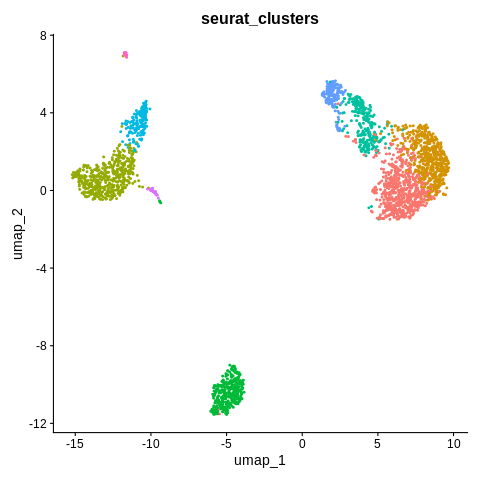

In [ ]:
%%R
library(Seurat)
# ---- Download PBMC3k (10x) ----
url <- "https://cf.10xgenomics.com/samples/cell/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz"
system(paste("wget -q -O pbmc3k.tar.gz", shQuote(url)))
system("tar -xzf pbmc3k.tar.gz")

data_dir <- "filtered_gene_bc_matrices/hg19"
counts <- Seurat::Read10X(data.dir = data_dir)

pbmc <- CreateSeuratObject(counts = counts, project = "pbmc3k", min.cells = 3, min.features = 200)
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")
pbmc <- subset(pbmc, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)

# ---- Standard Seurat workflow (light) ----
pbmc <- NormalizeData(pbmc)
pbmc <- FindVariableFeatures(pbmc, selection.method = "vst", nfeatures = 2000)
pbmc <- ScaleData(pbmc, features = VariableFeatures(pbmc))
pbmc <- RunPCA(pbmc, features = VariableFeatures(pbmc))
pbmc <- FindNeighbors(pbmc, dims = 1:20)
pbmc <- FindClusters(pbmc, resolution = 0.5)

# export UMAP color(R)
clusters <- sort(unique(as.character(pbmc$seurat_clusters)))
cols <- grDevices::hcl(h = seq(15, 375, length.out = length(clusters) + 1)[- (length(clusters)+1)],
                       c = 100, l = 65)

df_cols <- data.frame(seurat_clusters = clusters, color = cols)
write.csv(df_cols, "/content/colors_seurat_clusters.csv", row.names = FALSE)

pbmc <- RunUMAP(pbmc, dims = 1:20)

saveRDS(pbmc, "/content/pbmc3k_seurat.rds")
names(cols) <- clusters
DimPlot(pbmc, group.by = "seurat_clusters", cols = cols) + NoLegend()

## Export Seurat → folder for Python (Code — bash)

In [ ]:
%%bash
Rscript /content/export_to_curator.R \
  --in_rds /content/pbmc3k_seurat.rds \
  --outdir /content/out_seurat \
  --cluster_col seurat_clusters

ls -lh /content/out_seurat


total 26M
-rw-r--r-- 1 root root  44K Dec 29 01:10 barcodes.tsv
-rw-r--r-- 1 root root  26M Dec 29 01:10 counts.mtx
-rw-r--r-- 1 root root  96K Dec 29 01:10 features.tsv
-rw-r--r-- 1 root root 160K Dec 29 01:10 obs.csv
-rw-r--r-- 1 root root 3.4K Dec 29 01:10 sessionInfo.txt
-rw-r--r-- 1 root root 139K Dec 29 01:10 umap.csv


Preparing export for LLM-scCurator (file-based handoff)...
 -> assay = RNA
 -> counts: 13714 genes x 2638 cells
 -> UMAP found: exporting umap.csv
✅ Export completed: /content/out_seurat


##  Load export as AnnData + reuse Seurat colors + normalize (Code — Python)

🔒 Random seed set to 42 for reproducibility.


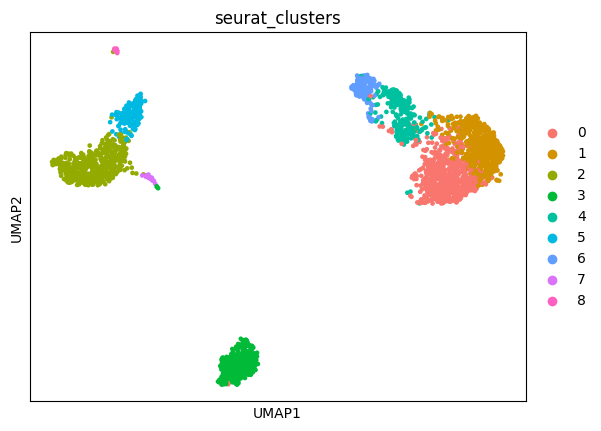

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.5', 'seurat_clusters'
    uns: 'seurat_clusters_colors'
    obsm: 'X_umap'

In [ ]:
import scanpy as sc
from scipy.io import mmread
import anndata as ad

import pandas as pd
import numpy as np
import random, os
import time
import matplotlib.pyplot as plt

import google.generativeai as genai
import llm_sc_curator
from llm_sc_curator import LLMscCurator
from llm_sc_curator.masking import FeatureDistiller

import warnings
warnings.filterwarnings("ignore")

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print(f"🔒 Random seed set to {RANDOM_SEED} for reproducibility.")

outdir = "/content/out_seurat"

# counts.mtx is genes x cells -> convert to cells x genes for AnnData
X = mmread(f"{outdir}/counts.mtx").tocsr().T.tocsr()

var = pd.read_csv(f"{outdir}/features.tsv", sep="\t", header=None, names=["gene"])
obs = pd.read_csv(f"{outdir}/obs.csv").set_index("cell_id")

adata = ad.AnnData(
    X=X,
    obs=obs.loc[obs.index, :],
    var=pd.DataFrame(index=var["gene"].astype(str).tolist()),
)

# Optional: reuse Seurat UMAP
umap_path = f"{outdir}/umap.csv"
if os.path.exists(umap_path):
    umap = pd.read_csv(umap_path).set_index("cell_id")
    adata.obsm["X_umap"] = umap.loc[adata.obs_names, ["UMAP1","UMAP2"]].to_numpy()

# Reuse Seurat cluster order + colors (Scanpy expects "<key>_colors" in adata.uns)
dfc = pd.read_csv("/content/colors_seurat_clusters.csv")
order = dfc["seurat_clusters"].astype(str).tolist()
adata.obs["seurat_clusters"] = adata.obs["seurat_clusters"].astype(str)
adata.obs["seurat_clusters"] = pd.Categorical(adata.obs["seurat_clusters"], categories=order, ordered=True)
adata.uns["seurat_clusters_colors"] = dfc["color"].tolist()
sc.pl.umap(adata, color=["seurat_clusters"])
adata

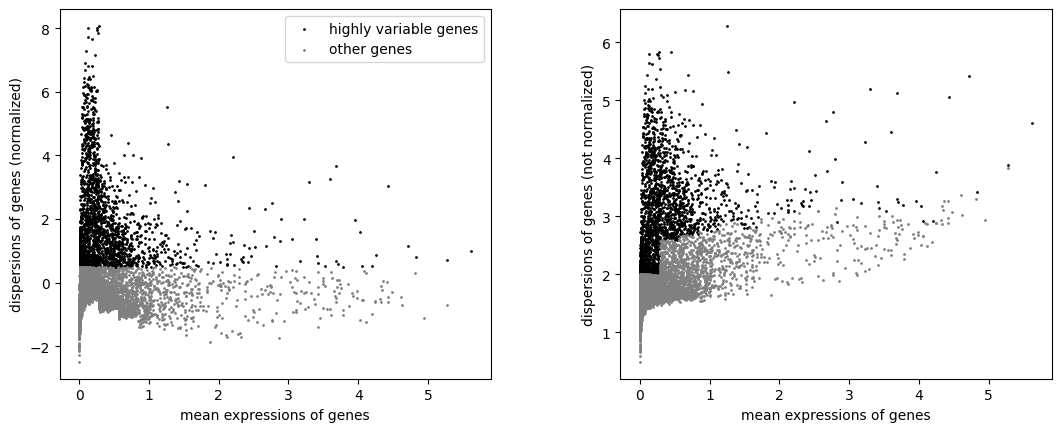

In [ ]:
# Keep a copy of raw counts, then normalize in Python for LLM-scCurator (.X must be log1p)
adata.layers["counts"] = adata.X.copy()

# Normalize + log1p (standard)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# HVG selection
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    flavor="seurat",
    subset=False,
)

sc.pl.highly_variable_genes(adata)

##  Run LLM-scCurator, noise masking and Gini-informed distillation

In [ ]:
ACCURACY_MODE = False  # set False for cheaper/faster

MODEL_NAME = "models/gemini-2.5-pro" if ACCURACY_MODE else "models/gemini-2.0-flash"
print("Using model:", MODEL_NAME)

Using model: models/gemini-2.0-flash


In [ ]:
# Recommended: store your key in Colab Secrets as "GEMINI_API_KEY"
from google.colab import userdata
GEMINI_API_KEY = userdata.get("GEMINI_API_KEY") or "YOUR_KEY_HERE"

In [ ]:
# Curator Initialize
curator = LLMscCurator(api_key=GEMINI_API_KEY, model_name=MODEL_NAME)
curator.set_global_context(adata)

In [ ]:
# Choose a cluster (edit if you want a specific one)
cluster_name = sorted(adata.obs["seurat_clusters"].astype(str).unique())[0]
print(f"cluster_name = {cluster_name}")

cluster_name = 0


In [ ]:
# --- Standard DE: Target vs Rest ---
N_GENES = 50
TMP = "__tmp_binary__"

# --- Standard: DE (Target vs Rest) ---
adata.obs[TMP] = "Rest"
adata.obs.loc[adata.obs["seurat_clusters"].astype(str) == str(cluster_name), TMP] = "Target"

sc.tl.rank_genes_groups(
    adata,
    groupby=TMP,
    groups=["Target"],
    reference="Rest",
    method="wilcoxon",
    use_raw=False,
)

df_std = sc.get.rank_genes_groups_df(adata, group="Target")
genes_std = df_std["names"].head(N_GENES).tolist()

adata.obs.drop(columns=[TMP], inplace=True, errors="ignore")

# --- Curated: LLM-scCurator ---
genes_cur = curator.curate_features(
    adata,
    group_col="seurat_clusters",
    target_group=str(cluster_name),
    n_top=N_GENES,
    use_statistics=True,
)

print("genes_std len =", len(genes_std))
print("genes_cur len =", len(genes_cur))


genes_std len = 50
genes_cur len = 50


In [ ]:
# --- Readable output: lists + rescued/dropped + table ---
def _fmt_list(title, genes, n=10, bullet="•"):
    genes = [str(g) for g in (genes or [])]
    head = genes[:n]
    body = "\n".join([f"{bullet} {g}" for g in head]) if head else f"{bullet} (empty)"
    return f"{title} (top {len(genes)}, showing {min(n, len(genes))})\n{body}"

std = [str(g) for g in genes_std]
cur = [str(g) for g in genes_cur]

std_set = set(std)
cur_set = set(cur)

rescued = [g for g in cur if g not in std_set]
dropped = [g for g in std if g not in cur_set]
overlap = [g for g in cur if g in std_set]

print(f"\nGene list summary: std={len(std)} | curated={len(cur)} | shared={len(overlap)} | rescued={len(rescued)} | dropped={len(dropped)}\n")

print("🟦 " + _fmt_list("Standard genes", std, n=10))
print()
print("🟥 " + _fmt_list("Curated genes", cur, n=10))
print()
print("➕ " + _fmt_list("Rescued (curated-only)", rescued, n=10))
print()
print("➖ " + _fmt_list("Dropped (std-only)", dropped, n=10))

TOP = 15
def _pad(xs, n=TOP):
    xs = [str(x) for x in (xs or [])][:n]
    return xs + [""] * (n - len(xs))

df_view = pd.DataFrame({
    "🏆 rank ": list(range(1, TOP + 1)),
    "🟦 standard ": _pad(genes_std, TOP),
    "🟥 curated ":  _pad(genes_cur, TOP),
})

df_view.insert(0, "cluster", str(cluster_name))
df_view


Gene list summary: std=50 | curated=50 | shared=8 | rescued=42 | dropped=42

🟦 Standard genes (top 50, showing 10)
• LTB
• IL32
• LDHB
• CD3D
• IL7R
• TPT1
• RPS12
• CD3E
• RPS3
• RPS25

🟥 Curated genes (top 50, showing 10)
• LTB
• IL32
• CD3D
• CD3E
• CD2
• AQP3
• GIMAP7
• HINT1
• GIMAP5
• ACAP1

➕ Rescued (curated-only) (top 42, showing 10)
• GIMAP5
• ACAP1
• CD3G
• FYB
• MAL
• PTPRCAP
• ITM2A
• TNFRSF4
• GIMAP4
• TRAF3IP3

➖ Dropped (std-only) (top 42, showing 10)
• LDHB
• IL7R
• TPT1
• RPS12
• RPS3
• RPS25
• RPS18
• JUNB
• RPS29
• EEF1A1


,cluster,🏆 rank,🟦 standard,🟥 curated
0,0,1,LTB,LTB
1,0,2,IL32,IL32
2,0,3,LDHB,CD3D
3,0,4,CD3D,CD3E
4,0,5,IL7R,CD2
5,0,6,TPT1,AQP3
6,0,7,RPS12,GIMAP7
7,0,8,CD3E,HINT1
8,0,9,RPS3,GIMAP5
9,0,10,RPS25,ACAP1


## (Optinal) Run LLM-scCurator per cluster, zero-shot cell-type annotation

In [ ]:
def ensure_json_result(x):
    """Normalize LLM outputs to a dict with consistent keys."""
    if isinstance(x, dict):
        return {
            "cell_type":  x.get("cell_type", "Unknown"),
            "confidence": x.get("confidence", "Low"),
            "reasoning":  x.get("reasoning", ""),
        }
    elif isinstance(x, str):
        return {
            "cell_type":  x,
            "confidence": "Low",
            "reasoning":  "",
        }
    else:
        return {
            "cell_type":  "Error",
            "confidence": "Low",
            "reasoning":  repr(x),
        }

unique_clusters = sorted(adata.obs["seurat_clusters"].astype(str).unique())

rows = []
cluster2type = {}
cluster2conf = {}
cluster2reason = {}

for i, cluster_name in enumerate(unique_clusters, start=1):
    print(f"\n[{i}/{len(unique_clusters)}] Processing: cluster{cluster_name}")

    genes_cur = curator.curate_features(
        adata,
        group_col="seurat_clusters",
        target_group=str(cluster_name),
        use_statistics=True,
    )

    try:
        if genes_cur:
            raw_cur = curator.annotate(genes_cur, use_auto_context=True)
        else:
            raw_cur = {
                "cell_type": "NoGenes",
                "confidence": "Low",
                "reasoning": "Curated gene list empty",
            }
        res_cur = ensure_json_result(raw_cur)
    except Exception as e:
        print(f"[WARN] Curated annotate failed for {cluster_name}: {e}")
        res_cur = ensure_json_result(
            {"cell_type": "Error", "confidence": "Low", "reasoning": str(e)}
        )

    ct = str(res_cur.get("cell_type", ""))
    cf = str(res_cur.get("confidence", ""))
    rs = str(res_cur.get("reasoning", ""))

    cluster2type[str(cluster_name)] = ct
    cluster2conf[str(cluster_name)] = cf
    cluster2reason[str(cluster_name)] = rs

    rows.append({
        "seurat_cluster": str(cluster_name),
        "n_cells": int((adata.obs["seurat_clusters"].astype(str) == str(cluster_name)).sum()),
        "Curated_CellType": ct,
        "Curated_Confidence": cf,
        "Curated_Reasoning": rs,
        "Curated_Genes": ";".join(map(str, genes_cur)) if genes_cur else "",
    })

    time.sleep(3) # be gentle with API rate limits

# Add per-cell label (cluster → cell label)
adata.obs["Curated_CellType"] = adata.obs["seurat_clusters"].astype(str).map(cluster2type).fillna("Unknown")
df_cluster = pd.DataFrame(rows)
df_map = df_cluster[["seurat_cluster","Curated_CellType","Curated_Confidence","Curated_Reasoning","Curated_Genes"]].copy()
df_map.to_csv("/content/cluster_curated_map.csv", index=False)
print("Wrote /content/cluster_curated_map.csv")
df_map.head()



[1/9] Processing: cluster0

[2/9] Processing: cluster1

[3/9] Processing: cluster2

[4/9] Processing: cluster3

[5/9] Processing: cluster4

[6/9] Processing: cluster5

[7/9] Processing: cluster6

[8/9] Processing: cluster7

[9/9] Processing: cluster8
Wrote /content/cluster_curated_map.csv


,seurat_cluster,Curated_CellType,Curated_Confidence,Curated_Reasoning,Curated_Genes
0,0,CD4+ T cell,High,"The presence of CD3D, CD3E, CD2, CD3G, CD247, ...",LTB;IL32;CD3D;CD3E;CD2;AQP3;GIMAP7;HINT1;GIMAP...
1,1,CD8+ T cell,High,"The presence of CD3D, CD3E, CD3G, CD8A, and CD...",CD3D;CD3E;SELL;CD8B;LTB;HINT1;TRAF3IP3;CD3G;SR...
2,2,Monocyte,High,The gene list is enriched for canonical monocy...,LYZ;S100A9;S100A8;TYROBP;CST3;FCN1;S100A6;LGAL...
3,3,B cell,High,The gene list contains several key B cell mark...,CD74;CD79A;HLA-DRA;CD79B;HLA-DPB1;HLA-DQA1;MS4...
4,4,CD8+ cytotoxic T cell,High,"The gene list shows high expression of CD8A, C...",CCL5;NKG7;CST7;GZMA;CTSW;IL32;GZMK;CD3D;PTPRCA...


## Plot cluster colors + overlay Curated label text (Code — Python)

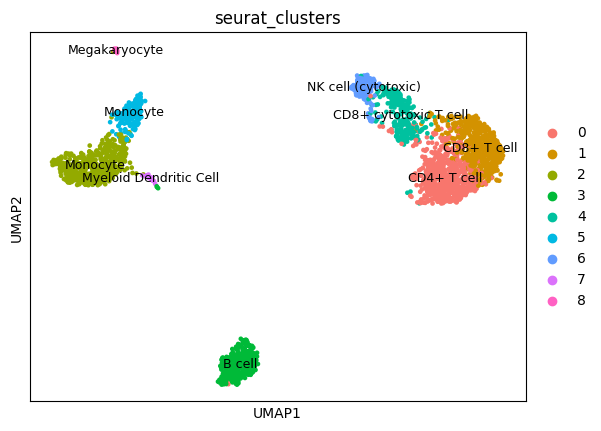

In [ ]:
dfc = pd.read_csv("/content/colors_seurat_clusters.csv")
order = dfc["seurat_clusters"].astype(str).tolist()

adata.obs["seurat_clusters"] = adata.obs["seurat_clusters"].astype(str)
adata.obs["seurat_clusters"] = pd.Categorical(adata.obs["seurat_clusters"], categories=order, ordered=True)
adata.uns["seurat_clusters_colors"] = dfc["color"].tolist()

sc.pl.umap(adata, color="seurat_clusters", show=False)

df_um = pd.DataFrame(adata.obsm["X_umap"], columns=["UMAP1", "UMAP2"], index=adata.obs_names)
df_um["cluster"] = adata.obs["seurat_clusters"].astype(str).values
df_um["label"] = adata.obs["Curated_CellType"].astype(str).fillna("Unknown").values

cent = df_um.groupby("cluster")[["UMAP1", "UMAP2"]].median()

ax = plt.gca()
for cl, (x, y) in cent.iterrows():
    lab = df_um.loc[df_um["cluster"] == cl, "label"].iloc[0]
    ax.text(x, y, lab, fontsize=9, ha="center", va="center")

plt.show()


## Bring labels back into Seurat metadata (pbmc$Curated_CellType) (Code — R)



In [ ]:
%%R
library(Seurat)

pbmc <- readRDS("/content/pbmc3k_seurat.rds")
df_map <- read.csv("/content/cluster_curated_map.csv", stringsAsFactors = FALSE)

# cluster -> label mapping
v_type <- setNames(df_map$Curated_CellType, df_map$seurat_cluster)

# ensure cluster column exists
if (!"seurat_clusters" %in% colnames(pbmc@meta.data)) {
  pbmc$seurat_clusters <- as.character(Idents(pbmc))
}

cl <- as.character(pbmc$seurat_clusters)
pbmc$Curated_CellType <- unname(v_type[cl])
pbmc$Curated_CellType[is.na(pbmc$Curated_CellType)] <- "Unknown"

table(pbmc$Curated_CellType)



                B cell            CD4+ T cell  CD8+ cytotoxic T cell 
                   345                    647                    267 
           CD8+ T cell          Megakaryocyte               Monocyte 
                   537                     14                    642 
Myeloid Dendritic Cell    NK cell (cytotoxic) 
                    29                    157 


## Verification table: top markers per Seurat cluster + assigned label (Code — R)

In [ ]:
%%R

Idents(pbmc) <- pbmc$seurat_clusters
m <- FindAllMarkers(pbmc, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)

top5 <- m[order(m$cluster, -m$avg_log2FC), ]
top5 <- top5[!duplicated(paste(top5$cluster, top5$gene)), ]
top5 <- do.call(rbind, lapply(split(top5, top5$cluster), head, 5))

# cluster -> Curated label (first value per cluster)
map <- tapply(as.character(pbmc$Curated_CellType), as.character(pbmc$seurat_clusters), function(x) x[1])

top5$Curated_CellType <- unname(map[as.character(top5$cluster)])
top5$Curated_CellType[is.na(top5$Curated_CellType)] <- "Unknown"

top5[, c("cluster","Curated_CellType","gene","avg_log2FC","pct.1","pct.2","p_val_adj")]


  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=04s  
  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=04s  
  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=05s  
  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=03s  
  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=04s  
  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=08s  
  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=07s  
  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=11s  
  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=04s  
                cluster       Curated_CellType          gene avg_log2FC pct.1
0.AQP3                0            CD4+ T cell          AQP3   2.416938 0.413
0.CD40LG              0            CD4+ T cell        CD40LG   2.236521 0.263
0.TRAT1               0            CD4+ T cell         TRAT1   1.771854 0.391
0.TRADD               

Calculating cluster 0
For a (much!) faster implementation of the Wilcoxon Rank Sum Test,
(default method for FindMarkers) please install the presto package
--------------------------------------------
install.packages('devtools')
devtools::install_github('immunogenomics/presto')
--------------------------------------------
After installation of presto, Seurat will automatically use the more 
efficient implementation (no further action necessary).
This message will be shown once per session
Calculating cluster 1
Calculating cluster 2
Calculating cluster 3
Calculating cluster 4
Calculating cluster 5
Calculating cluster 6
Calculating cluster 7
Calculating cluster 8


## Quick marker dotplot for sanity-checking labels

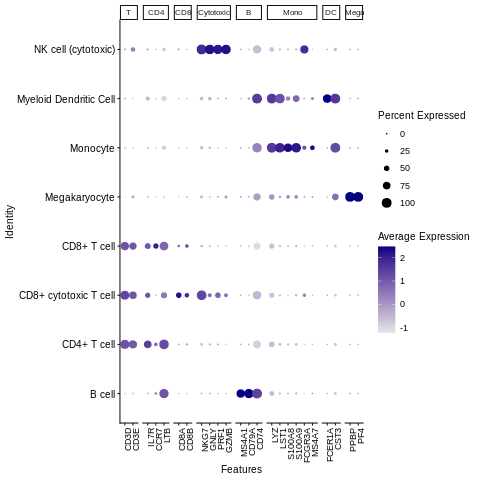

In [ ]:
%%R
library(ggplot2)

options(repr.plot.width = 14, repr.plot.height = 4)

DefaultAssay(pbmc) <- "RNA"
genes_in <- rownames(pbmc)

resolve_gene <- function(g, genes) {
  if (g %in% genes) return(g)
  hit <- grep(paste0("^", g, "([\\.-].+)?$"), genes, value = TRUE)
  if (length(hit) > 0) return(hit[1])
  return(NA_character_)
}

markers_grp <- list(
  "T"         = c("TRAC","CD3D","CD3E"),
  "CD4"       = c("IL7R","CCR7","LTB"),
  "CD8"       = c("CD8A","CD8B"),
  "Cytotoxic" = c("NKG7","GNLY","PRF1","GZMB"),
  "B"         = c("MS4A1","CD79A","CD74"),
  "Mono"      = c("LYZ","LST1","S100A8","S100A9","FCGR3A","MS4A7"),
  "DC"        = c("FCER1A","CST3"),
  "Mega"      = c("PPBP","PF4")
)

# Remove missing genes + prevent duplicates across groups (avoids factor-level errors)
filter_markers <- function(marker_list, genes) {
  used <- character(0)
  out <- list()
  for (nm in names(marker_list)) {
    gs <- marker_list[[nm]]
    gs2 <- vapply(gs, resolve_gene, character(1), genes = genes)
    gs2 <- unique(na.omit(gs2))
    gs2 <- gs2[!gs2 %in% used]
    used <- c(used, gs2)
    if (length(gs2) > 0) out[[nm]] <- gs2
  }
  out
}

markers3 <- filter_markers(markers_grp, genes_in)

pbmc$Curated_CellType[is.na(pbmc$Curated_CellType)] <- "Unknown"
Idents(pbmc) <- pbmc$Curated_CellType

p <- DotPlot(
  pbmc,
  features = markers3,
  group.by = "Curated_CellType",
  dot.scale = 4,
  cols = c("grey90", "navy")
) + RotatedAxis()

p + theme_classic(base_size = 10) +
  theme(
    axis.text.x = element_text(angle = 90, hjust = 1, vjust = 1, size = 9),
    axis.text.y = element_text(size = 10),
    legend.title = element_text(size = 10),
    legend.text  = element_text(size = 9)
  )


In [ ]:
%%R
sessionInfo()

R version 4.5.2 (2025-10-31)
Platform: x86_64-pc-linux-gnu
Running under: Ubuntu 22.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3 
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/liblapack.so.3;  LAPACK version 3.10.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] ggplot2_4.0.1      future_1.68.0      Seurat_5.4.0       SeuratObject_5.3.0
[5] sp_2.2-0          

loaded via a namespace (and not attached):
  [1] deldir_2.0-4         